In [82]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
% ls -1 data/

test_seas2_0.871.csv
test_seas_0.104.csv


In [5]:
df_01 = pd.read_csv('data/test_seas_0.104.csv')
df_09 = pd.read_csv('data/test_seas2_0.871.csv')

In [6]:
df_01.shape

(200, 10000)

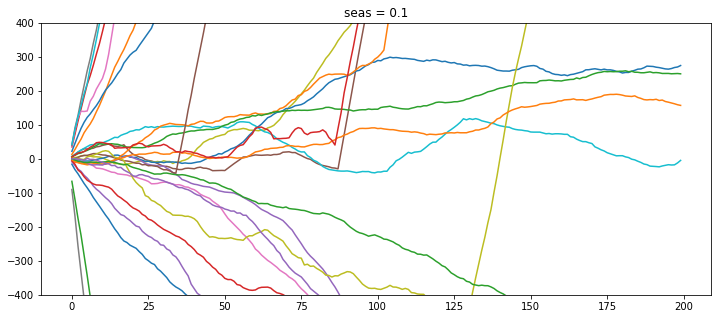

In [168]:
df_01.sample(25, random_state=123, axis=1).\
      plot(linestyle='-',
           marker=None, logy=False,
           legend=False, figsize=(12,5),
           ylim=(-400,400),
           title='seas = 0.1'
          );

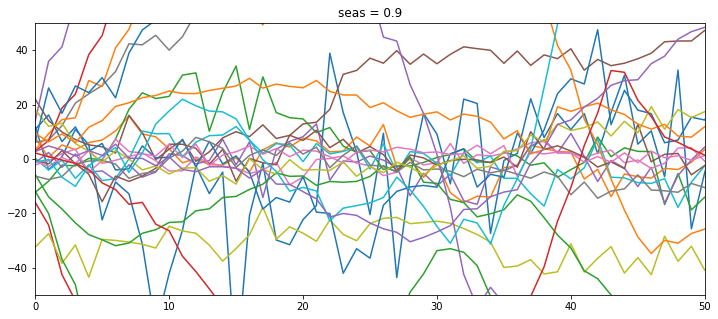

In [169]:
df_09.sample(25,random_state=123, axis=1).\
      plot(linestyle='-', logy=False,
           legend=False, figsize=(12,5),
           ylim=(-50,50), xlim=(0, 50),
           title='seas = 0.9');

## Preprocessing

## Making datasets + Preprocessing
We do following:

1) add min value to makes TS positive.

2) log.

3) divide by max in order to make $TS \in [0,1]$.


In [191]:
def norm_ts(data):
    """
    1) add min value to makes TS positive. 
    2) log. 
    3) divide by max in order to make  TS∈[0,1] .
    """
    min_val = np.min(data)
    data_log = np.log(data - min_val + 1)
    
    max_val_after_log = np.max(data_log)
    return data_log / max_val_after_log, max_val_after_log, min_val

In [215]:
data_01 = df_01.values.T
data_09 = df_09.values.T
data_01_09 = np.concatenate((data_01, data_09), axis=0)

data_01_norm, max01, min01 = norm_ts(data_01)
data_09_norm, max09, min09 = norm_ts(data_09)
data_01_09_norm = np.concatenate((data_01_norm, data_09_norm), axis=0)


## Let's plot after

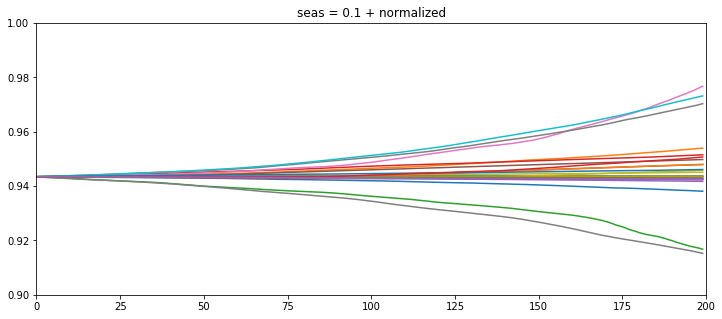

In [200]:
pd.DataFrame(data_01_norm.T).\
                              sample(25, random_state=123, axis=1).\
                              plot(linestyle='-', logy=False,
                              legend=False, figsize=(12,5),
                              ylim=(.9,1), xlim=(0, 200),
                              title='seas = 0.1 + normalized');

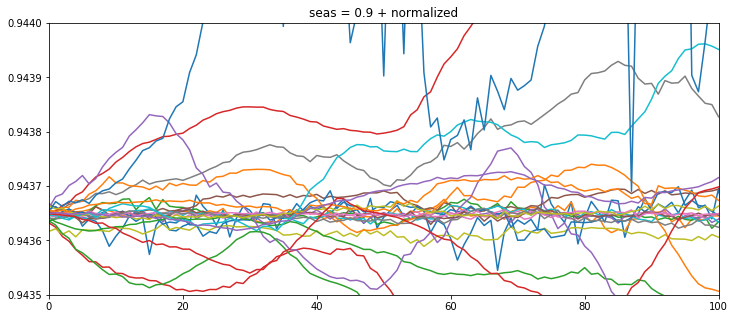

In [202]:
pd.DataFrame(data_09_norm.T).\
                              sample(25, random_state=123, axis=1).\
                              plot(linestyle='-', logy=False,
                              legend=False, figsize=(12,5),
                              ylim=(.9435,.944), xlim=(0, 100),
                              title='seas = 0.9 + normalized');

In [89]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, BatchNormalization, Dropout
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


In [232]:
def mse(Y, YH):
     return np.square(Y - YH).mean()
    

def train_test_split_reshape(data, n_steps_for_train=175):
    """reshape + split train test 50-50"""
    np.random.shuffle(data)
    n_samples = data.shape[0]
    x_train = data[:n_samples/2, :n_steps_for_train].reshape(n_samples/2, n_steps_for_train, 1)
    y_train = data[:n_samples/2, n_steps_for_train:]

    x_test = data[n_samples/2:, :n_steps_for_train].reshape(n_samples/2, n_steps_for_train, 1)
    y_test = data[n_samples/2:, n_steps_for_train:]
    return x_train, y_train, x_test, y_test


In [233]:
def cnn_model(x_train, y_train, batch_size, epochs=100):
    
    
    input_dim = n_steps_for_train
    model = Sequential()
    model.add(Convolution1D(filters=6, kernel_size=4, input_shape=(input_dim ,1)))
    model.add(Flatten())
    model.add(Dense(units=64, kernel_initializer='normal'))
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(units=60, actiivation='relu'))
    # model.add(Dense(units=40, activation='relu'))
    model.add(Dense(units=200-input_dim, activation='linear'))


    sgd = optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error',
                  optimizer='sgd',
                  metrics=['mae'])

    history = model.fit(x_train, y_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_split=.3, verbose=2)
    return model, history

## CNN for 2 cluster together

In [234]:
x_train, y_train, x_test, y_test = train_test_split_reshape(data_01_09_norm)

In [236]:
model, history = cnn_model(x_train=x_train, y_train=y_train, batch_size=4, epochs=15)

Train on 7000 samples, validate on 3000 samples
Epoch 1/15
 - 2s - loss: 0.0049 - mean_absolute_error: 0.0123 - val_loss: 1.2099e-04 - val_mean_absolute_error: 0.0034
Epoch 2/15
 - 2s - loss: 9.2148e-05 - mean_absolute_error: 0.0036 - val_loss: 1.2571e-04 - val_mean_absolute_error: 0.0041
Epoch 3/15
 - 2s - loss: 9.1774e-05 - mean_absolute_error: 0.0036 - val_loss: 1.2291e-04 - val_mean_absolute_error: 0.0037
Epoch 4/15
 - 2s - loss: 9.1897e-05 - mean_absolute_error: 0.0036 - val_loss: 1.2065e-04 - val_mean_absolute_error: 0.0034
Epoch 5/15
 - 2s - loss: 9.0879e-05 - mean_absolute_error: 0.0035 - val_loss: 1.3219e-04 - val_mean_absolute_error: 0.0061
Epoch 6/15
 - 2s - loss: 9.0499e-05 - mean_absolute_error: 0.0035 - val_loss: 1.1868e-04 - val_mean_absolute_error: 0.0037
Epoch 7/15
 - 2s - loss: 8.9851e-05 - mean_absolute_error: 0.0035 - val_loss: 1.1790e-04 - val_mean_absolute_error: 0.0038
Epoch 8/15
 - 2s - loss: 8.9703e-05 - mean_absolute_error: 0.0035 - val_loss: 1.1698e-04 - val_

## CNN for "low seasonality cluster"

In [237]:
x_train, y_train, x_test, y_test = train_test_split_reshape(data_01_norm)
model, history = cnn_model(x_train=x_train, y_train=y_train, batch_size=4, epochs=15)

Train on 3500 samples, validate on 1500 samples
Epoch 1/15
 - 1s - loss: 0.0068 - mean_absolute_error: 0.0194 - val_loss: 1.4011e-04 - val_mean_absolute_error: 0.0056
Epoch 2/15
 - 1s - loss: 1.4512e-04 - mean_absolute_error: 0.0053 - val_loss: 1.4406e-04 - val_mean_absolute_error: 0.0063
Epoch 3/15
 - 1s - loss: 1.4457e-04 - mean_absolute_error: 0.0052 - val_loss: 1.3716e-04 - val_mean_absolute_error: 0.0052
Epoch 4/15
 - 1s - loss: 1.4466e-04 - mean_absolute_error: 0.0052 - val_loss: 1.3910e-04 - val_mean_absolute_error: 0.0050
Epoch 5/15
 - 1s - loss: 1.4414e-04 - mean_absolute_error: 0.0052 - val_loss: 1.8279e-04 - val_mean_absolute_error: 0.0095
Epoch 6/15
 - 1s - loss: 1.4189e-04 - mean_absolute_error: 0.0052 - val_loss: 1.3863e-04 - val_mean_absolute_error: 0.0051
Epoch 7/15
 - 1s - loss: 1.4203e-04 - mean_absolute_error: 0.0052 - val_loss: 1.4587e-04 - val_mean_absolute_error: 0.0057
Epoch 8/15
 - 1s - loss: 1.4248e-04 - mean_absolute_error: 0.0052 - val_loss: 1.3716e-04 - val_

## CNN for "high seasonality cluster"

In [238]:
x_train, y_train, x_test, y_test = train_test_split_reshape(data_09_norm)
model, history = cnn_model(x_train=x_train, y_train=y_train, batch_size=4, epochs=15)

Train on 3500 samples, validate on 1500 samples
Epoch 1/15
 - 1s - loss: 0.0205 - mean_absolute_error: 0.0387 - val_loss: 8.0521e-06 - val_mean_absolute_error: 3.7608e-04
Epoch 2/15
 - 1s - loss: 1.8973e-06 - mean_absolute_error: 4.1964e-04 - val_loss: 8.0492e-06 - val_mean_absolute_error: 4.1586e-04
Epoch 3/15
 - 1s - loss: 1.8895e-06 - mean_absolute_error: 4.1749e-04 - val_loss: 8.0288e-06 - val_mean_absolute_error: 3.7243e-04
Epoch 4/15
 - 1s - loss: 1.8844e-06 - mean_absolute_error: 4.1600e-04 - val_loss: 8.0187e-06 - val_mean_absolute_error: 3.6578e-04
Epoch 5/15
 - 1s - loss: 1.8792e-06 - mean_absolute_error: 4.1778e-04 - val_loss: 8.0576e-06 - val_mean_absolute_error: 4.8724e-04
Epoch 6/15
 - 1s - loss: 1.8770e-06 - mean_absolute_error: 4.1415e-04 - val_loss: 8.0939e-06 - val_mean_absolute_error: 5.5142e-04
Epoch 7/15
 - 1s - loss: 1.8654e-06 - mean_absolute_error: 4.1947e-04 - val_loss: 8.0168e-06 - val_mean_absolute_error: 4.3024e-04
Epoch 8/15
 - 1s - loss: 1.8703e-06 - mean_

In [239]:
np.set_printoptions(precision=5, threshold=None, edgeitems=None, linewidth=None, suppress=True)